# Analiza sentymentu


In [1]:
import findspark
spark_path = '/home/wojciech/spark-2.3.1-bin-hadoop2.7'
findspark.init(spark_path)

In [2]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.ml import PipelineModel
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
from IPython import display
import subprocess
import pandas as pd
from time import sleep
%matplotlib inline

In [3]:
host = "127.0.0.1"
port = 5555
time = 5*60 #Okres przez który wiadomości będą pozyskiwane. 5*60 sekund
interval = 30 #Świeża porcja wpisów jest analizowana co 30 sekund
model_name = 'NaiveBayesModel'

In [4]:
subprocess.Popen(['python','client.py',host,str(port),str(time)])
sleep(1)

In [5]:
sc = SparkContext("local[4]", "SparkTwitter")
sqlContext = SQLContext(sc)
ssc = StreamingContext(sc, interval)
socket_stream = ssc.socketTextStream(host, port)
#socket_stream.pprint()
# ssc.start() 
pip = PipelineModel.load(model_name)

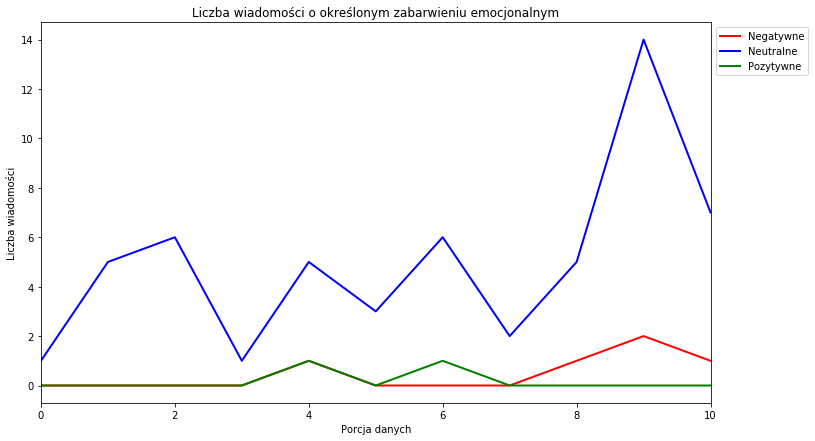

In [6]:
def map_fun(x):
    if x>=.95:
        return 2
    if x<=.05:
        return 0
    return 1

messages = [[],[],[]]

def plot(messages):
    plt.figure(figsize=(12,7))
    plt.plot(messages[0],color='red',linewidth=2,label='Negatywne')
    plt.plot(messages[1],color='blue',linewidth=2,label='Neutralne')
    plt.plot(messages[2],color='green',linewidth=2,label='Pozytywne')
    plt.legend(bbox_to_anchor=(1.0, 1))
    plt.xlim([0,time/interval])
    plt.title('Liczba wiadomości o określonym zabarwieniu emocjonalnym')
    plt.xlabel('Porcja danych')
    plt.ylabel('Liczba wiadomości')
    plt.show()

def process(rdd):
    try:
        d=defaultdict(int,pip.transform(rdd.toDF()).select('probability').rdd\
            .map(lambda x:map_fun(x[0][1]))\
            .map(lambda x:(x,1))\
            .reduceByKey(lambda a,b:a+b).collect())
        for i in range(3):
            messages[i].append(d[i])
        display.clear_output(wait=True)
        plot(messages)
    except Exception as e:
        print(e)

fields = ("text")
Tweet = namedtuple( 'Tweet', fields )
socket_stream.map( lambda rec: Tweet(rec) ).foreachRDD(lambda x:process(x))
ssc.start()
ssc.awaitTerminationOrTimeout(time+interval);

In [7]:
ssc.stop()